In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory


In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef)

61532

In [7]:
F = (ef['use_record'] == 1)

In [8]:
ef = ef.loc[F]
len(ef)

9320

In [9]:
ef.ea_lv_systolic.value_counts()

 0.0    2297
-1.0     308
 3.0     220
 1.0     183
 2.0     147
-2.0      71
-3.0      30
Name: ea_lv_systolic, dtype: int64

## Calculate MDRD and add to features table

In [10]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [11]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [12]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

In [13]:
sum(np.isnan(ef.mdrd))

248

In [14]:
sum(np.isnan(ef.bmi))

3242

In [15]:
sum(np.isnan(ef.fb_day1_balance_ml))

637

In [16]:
sum(np.isnan(ef.fb_day2_balance_ml))

2041

In [17]:
sum(np.isnan(ef.fb_day3_balance_ml))

3832

## Create general features table

In [18]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [19]:
## is apache score everr missing?
sum(np.isnan(ef.apsiii))

0

In [44]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

no_echo = np.isnan(ef.ea_key)
#X['no_echo'] = no_echo.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = ((np.isnan(lvsys) | (lvsys < -1)) & ~no_echo).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

tvpulm = ef.ea_tv_pulm_htn
tv_missing = ((np.isnan(tvpulm) | (tvpulm < -2)) & ~no_echo).astype(float)
tv_normal = (tvpulm == 0).astype(float)
tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
X['plm_htn_missing'] = tv_missing
X['plm_htn_normal'] = tv_normal
X['plm_htn_abnormal'] = tv_abnormal

rvcavity = ef.ea_rv_cavity
rvcav_missing = ((np.isnan(rvcavity) | (rvcavity < -2)) & ~no_echo).astype(float)
rvcav_normal = (rvcavity == 0).astype(float)
rvcav_small = (rvcavity == -1).astype(float)
rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
X['rvcav_missing'] = rvcav_missing
X['rvcav_normal'] = rvcav_normal
X['rvcav_small'] = rvcav_small
X['rvcav_dilated'] = rvcav_dilated

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
X['sicu'] = sicu
X['nsicu'] = nsicu
X['micu'] = micu

X.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,plm_htn_abnormal,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated,lactate,lactate_missing,sicu,nsicu,micu
1,0.100055,0.0,0.0,-0.002727,0.0,1.0,0.0,0.436365,0.0,-0.204530,...,1.0,0.0,1.0,0.0,0.0,0.716411,0.0,0.0,1.0,0.0
16,0.450966,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.364830,...,0.0,0.0,0.0,0.0,0.0,3.776100,0.0,0.0,0.0,1.0
20,0.164522,0.0,0.0,0.044261,0.0,0.0,0.0,0.404471,0.0,0.145846,...,0.0,0.0,1.0,0.0,0.0,0.065522,0.0,0.0,0.0,1.0
22,0.305922,0.0,0.0,-0.088287,0.0,0.0,0.0,0.729504,0.0,-1.036671,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0
25,0.390890,0.0,0.0,0.000000,1.0,0.0,0.0,-0.400352,0.0,2.204301,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,1.0


## Examine relationship between variables

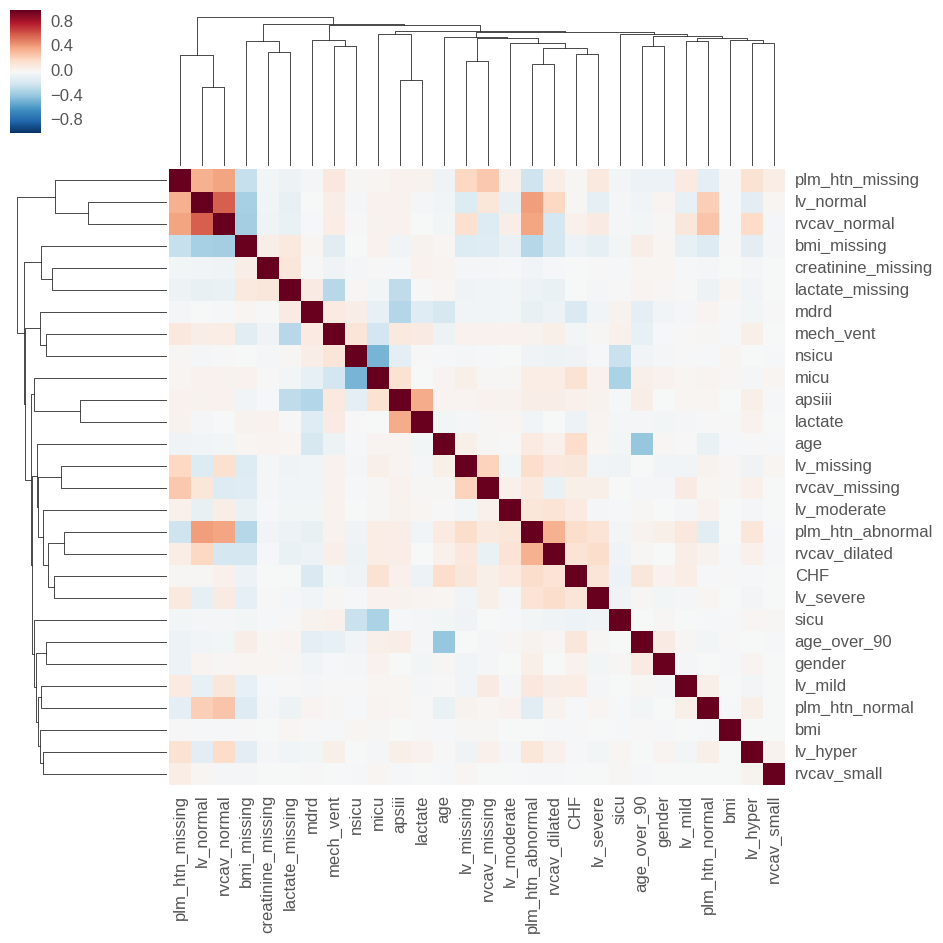

In [45]:
g = sns.clustermap(X.corr())
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0)

## Features matrix with fluid balance

In [46]:
## make the features table. include fluid balance on days 1,2,3 of ICU stay
X_mortality = X.copy()

fluid_day1 = ef.fb_day1_balance_ml.values
fl_missing = np.isnan(fluid_day1) | ef.fb_day1_balance_truncated.eq(1).values # also filter insane fluid balances
fluid_day1[~fl_missing] = normalize(fluid_day1[~fl_missing])
fluid_day1[fl_missing] = 0
X_mortality['fluid_day1'] = fluid_day1
X_mortality['fluid_day1_missing'] = fl_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
fl_missing = np.isnan(fluid_day2) | ef.fb_day2_balance_truncated.eq(1).values
fluid_day2[~fl_missing] = normalize(fluid_day2[~fl_missing])
fluid_day2[fl_missing] = 0
X_mortality['fluid_day2'] = fluid_day2
X_mortality['fluid_day2_missing'] = fl_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
fl_missing = np.isnan(fluid_day3) | ef.fb_day3_balance_truncated.eq(1).values
fluid_day3[~fl_missing] = normalize(fluid_day3[~fl_missing])
fluid_day3[fl_missing] = 0
X_mortality['fluid_day3'] = fluid_day3
X_mortality['fluid_day3_missing'] = fl_missing.astype(float)

y_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')
y_mortality = y_mortality.astype(float)
X_mortality['mortality_day30'] = y_mortality

In [47]:
y_mortality.mean(), y_mortality.sum(), len(y_mortality)

(0.2811158798283262, 2620.0, 9320)

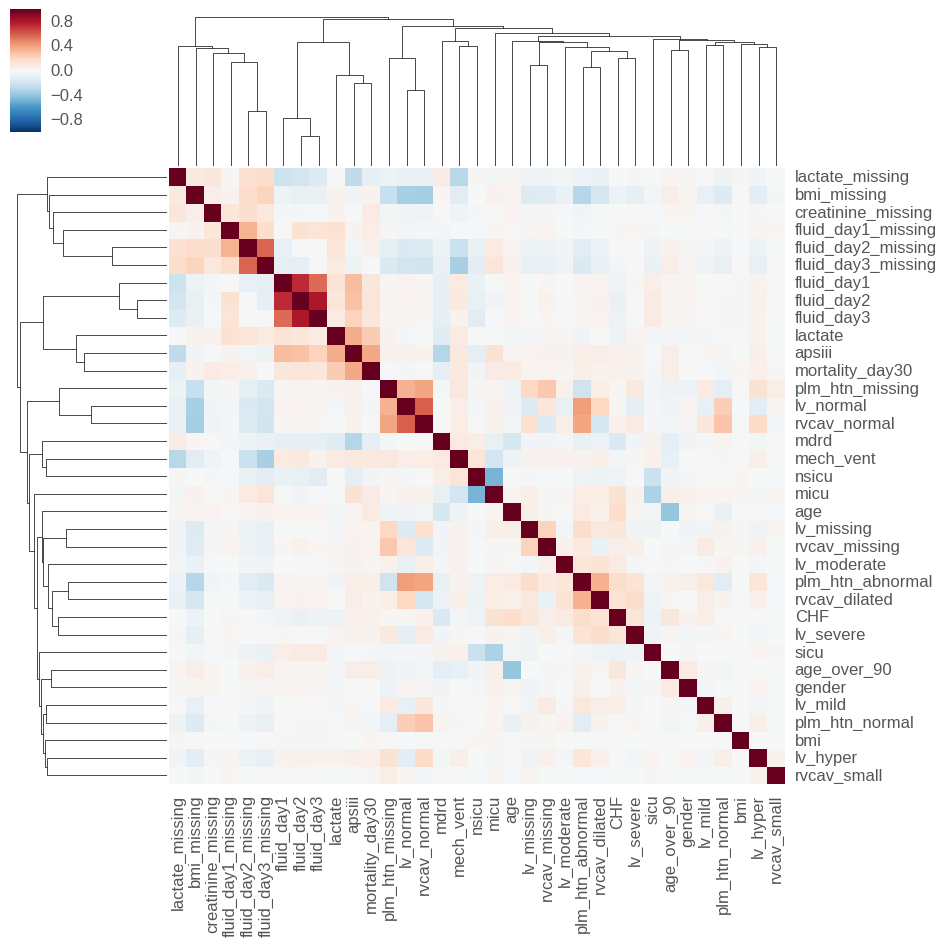

In [48]:
g = sns.clustermap(X_mortality.corr())
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0)

In [50]:
mortality_corr = X_mortality.corr()['mortality_day30']
mortality_corr.sort_values(ascending=False)

mortality_day30       1.000000
apsiii                0.385589
lactate               0.255529
fluid_day2            0.130941
fluid_day3            0.118848
fluid_day1            0.116341
mech_vent             0.097603
creatinine_missing    0.092368
age                   0.090260
micu                  0.080892
fluid_day1_missing    0.075425
age_over_90           0.068061
plm_htn_abnormal      0.059298
lv_hyper              0.049958
CHF                   0.049683
fluid_day2_missing    0.048103
rvcav_dilated         0.044001
bmi_missing           0.042406
lv_severe             0.033258
lv_missing            0.030610
rvcav_missing         0.025283
bmi                   0.019824
lv_moderate           0.014704
rvcav_small           0.011296
fluid_day3_missing    0.002568
gender               -0.004865
lv_mild              -0.009366
rvcav_normal         -0.011316
plm_htn_missing      -0.012918
lv_normal            -0.020893
sicu                 -0.021397
plm_htn_normal       -0.026900
nsicu   

## Some helper model building functions

In [51]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [52]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

In [ ]:
def calc_CI_pval_rank(samples):
    for col in samples.columns:
        x = samples[col]

## Simple linear model for predicting 30-day mortality

In [68]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    logistic(X_mortality.drop('mortality_day30', axis=1), y_mortality)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 4587.165367
         Iterations: 45
         Function evaluations: 56
         Gradient evaluations: 56


100%|██████████| 2000/2000 [05:14<00:00,  6.37it/s]


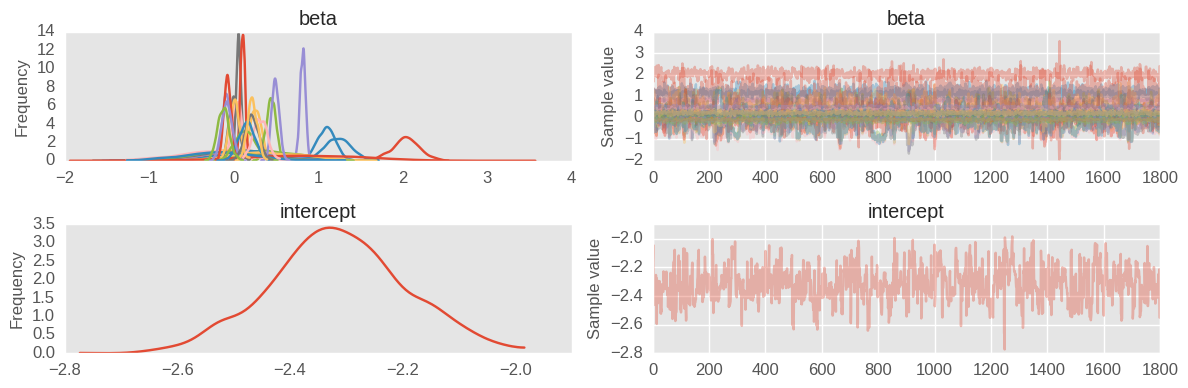

In [69]:
_ = pm.traceplot(trace[200:])

In [71]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_mortality.drop('mortality_day30', axis=1).columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,sicu,nsicu,micu,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
0,1.679002,0.896262,-0.108036,0.051996,0.180104,0.486930,0.194375,0.111960,1.239612,0.835983,...,0.012951,0.124909,0.215691,-0.063814,0.143183,-0.120717,0.161064,0.214007,0.021119,-2.161930
1,1.834744,1.211902,-0.056405,0.048519,0.381219,0.372416,-0.071269,0.074046,1.137563,0.791319,...,-0.086424,-0.011940,0.234683,-0.130258,0.056613,-0.013187,0.078393,0.170182,-0.143067,-2.103738
2,1.674605,0.811200,-0.145923,0.066773,0.081966,0.380417,0.197408,0.112163,1.238332,0.838101,...,0.023368,0.136319,0.245734,-0.060081,0.233935,-0.025145,0.239386,0.092721,-0.034864,-2.044599
3,2.307438,1.320861,-0.119310,0.055605,0.132808,0.433613,0.132099,0.141957,1.296355,0.878211,...,0.006693,0.196012,0.286567,0.038218,0.119071,-0.224192,0.188486,0.233433,-0.032362,-2.380436
4,2.354277,1.067461,-0.157953,0.049435,0.263617,0.442500,0.038489,0.137325,1.330441,0.849419,...,0.007871,0.025142,0.322787,0.023383,0.338677,-0.224214,0.089305,0.273302,-0.101472,-2.352822


In [72]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,sicu,nsicu,micu,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,...,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.035994,1.094982,-0.078915,0.060578,0.258573,0.441319,0.040801,0.106652,1.231710,0.817964,...,0.008975,0.135239,0.312043,-0.072303,0.153875,-0.079464,0.214172,0.219949,-0.121525,-2.315155
std,0.163428,0.108197,0.054112,0.031557,0.066883,0.057380,0.057990,0.027638,0.158845,0.032361,...,0.061075,0.115991,0.083053,0.042156,0.093184,0.061883,0.079443,0.058418,0.067780,0.120276
min,1.456807,0.679652,-0.255589,-0.043915,0.037510,0.223966,-0.175461,-0.006676,0.721467,0.713187,...,-0.174505,-0.228413,0.072267,-0.207968,-0.191396,-0.330706,-0.087121,0.025210,-0.333735,-2.773040
25%,1.935483,1.020638,-0.115025,0.040311,0.212019,0.405358,0.001179,0.087943,1.127748,0.795142,...,-0.034133,0.054633,0.256500,-0.101368,0.091926,-0.121794,0.160919,0.182115,-0.168321,-2.390942
50%,2.038966,1.097600,-0.081619,0.059617,0.258364,0.442523,0.039799,0.106982,1.233808,0.819153,...,0.008852,0.133351,0.310143,-0.072990,0.156750,-0.080956,0.212095,0.218944,-0.121325,-2.318569
75%,2.145030,1.166718,-0.040436,0.079869,0.305844,0.479866,0.079032,0.125727,1.337673,0.839255,...,0.047780,0.214942,0.369855,-0.043763,0.215799,-0.037804,0.268216,0.260021,-0.077730,-2.237766
max,2.542034,1.456977,0.088774,0.184997,0.471967,0.633828,0.215969,0.190268,1.715710,0.931893,...,0.187586,0.517836,0.545832,0.056918,0.422079,0.140965,0.459579,0.396149,0.109871,-1.983972


In [73]:
W = sample_coefs.values[:,:X_mortality.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_mortality.values, W.T) + b
y_ppc = y_ppc.T
y_ppc.shape, y_mortality.shape

((1800, 9320), (9320,))

In [74]:
acc_ppc = (y_ppc > 0).astype(float) == y_mortality.values
acc_ppc = acc_ppc.mean(axis=1)

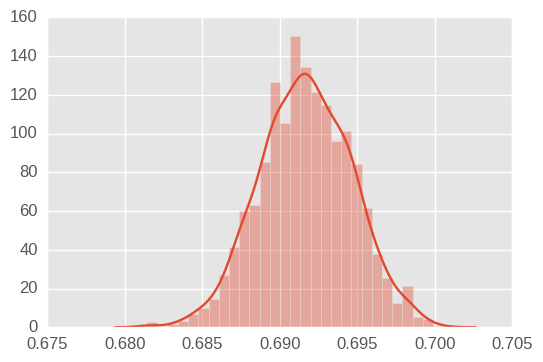

In [75]:
sns.distplot(acc_ppc)

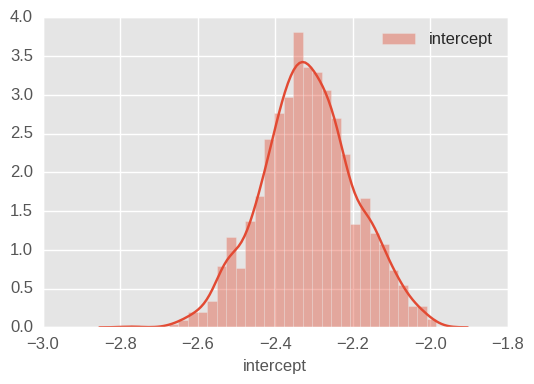

In [76]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.035994,1.094982,-0.078915,0.060578,0.258573
std,0.163428,0.108197,0.054112,0.031557,0.066883
min,1.456807,0.679652,-0.255589,-0.043915,0.037510
25%,1.935483,1.020638,-0.115025,0.040311,0.212019
50%,2.038966,1.097600,-0.081619,0.059617,0.258364
75%,2.145030,1.166718,-0.040436,0.079869,0.305844
max,2.542034,1.456977,0.088774,0.184997,0.471967


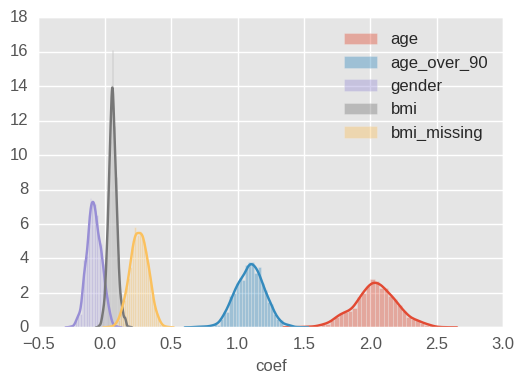

In [77]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.441319,0.040801,0.817964,0.106652,1.231710,0.493580,0.001904
std,0.057380,0.057990,0.032361,0.027638,0.158845,0.044785,0.058135
min,0.223966,-0.175461,0.713187,-0.006676,0.721467,0.327221,-0.202724
25%,0.405358,0.001179,0.795142,0.087943,1.127748,0.463014,-0.037311
50%,0.442523,0.039799,0.819153,0.106982,1.233808,0.492430,0.001512
75%,0.479866,0.079032,0.839255,0.125727,1.337673,0.523136,0.039036
max,0.633828,0.215969,0.931893,0.190268,1.715710,0.658843,0.191684


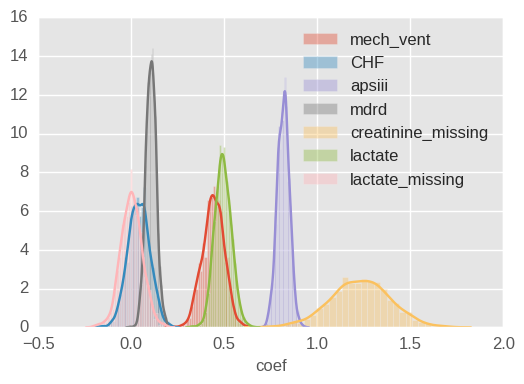

In [78]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,micu,sicu,nsicu
count,1800.000000,1800.000000,1800.000000
mean,0.312043,0.008975,0.135239
std,0.083053,0.061075,0.115991
min,0.072267,-0.174505,-0.228413
25%,0.256500,-0.034133,0.054633
50%,0.310143,0.008852,0.133351
75%,0.369855,0.047780,0.214942
max,0.545832,0.187586,0.517836


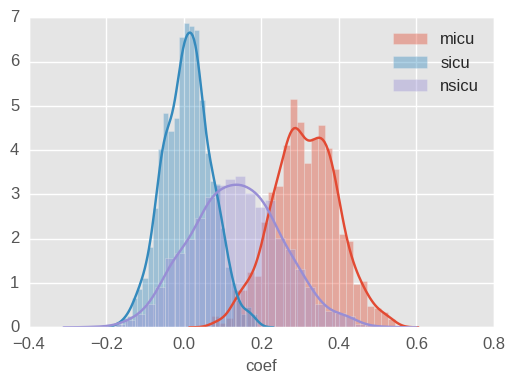

In [79]:
coefs = ['micu', 'sicu', 'nsicu']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.198072,-0.007026,0.420774,-0.176899,0.024499,0.230227
std,0.369659,0.361971,0.378904,0.387383,0.413387,0.379048
min,-1.071542,-1.335962,-0.910563,-1.500575,-1.464656,-1.216481
25%,-0.036505,-0.234095,0.177102,-0.431220,-0.253826,-0.015294
50%,0.183303,-0.020271,0.404889,-0.181848,0.010208,0.225096
75%,0.441130,0.242744,0.685722,0.093069,0.306921,0.481501
max,1.436417,1.046416,1.689654,0.975800,1.317439,1.293650


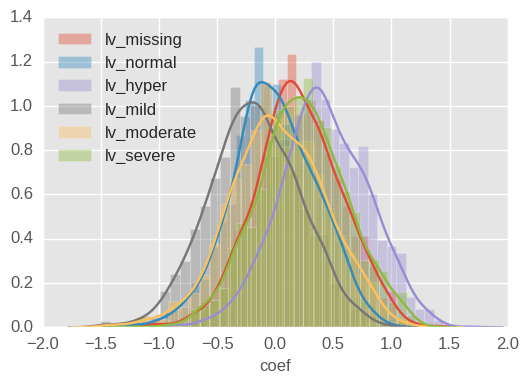

In [80]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.121612,-0.265422,0.825757,-0.155456
std,0.445547,0.440371,0.690598,0.448737
min,-1.162624,-1.272523,-1.938030,-1.262156
25%,-0.408207,-0.555122,0.360027,-0.455868
50%,-0.142358,-0.287184,0.834763,-0.173418
75%,0.161788,0.017635,1.324947,0.126245
max,1.419558,1.210885,3.569620,1.318368


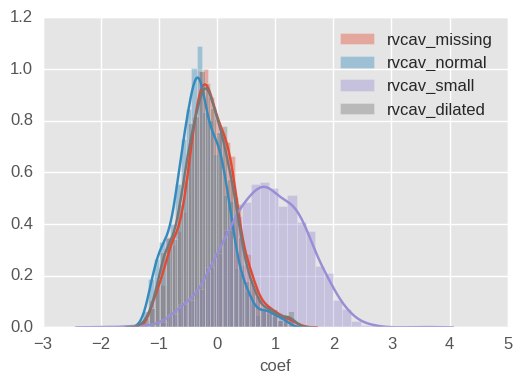

In [82]:
coefs = ['rvcav_missing', 'rvcav_normal', 'rvcav_small', 'rvcav_dilated']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,plm_htn_missing,plm_htn_normal,plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,0.034118,-0.029189,0.416559
std,0.433508,0.444910,0.433179
min,-1.552747,-1.666611,-1.227451
25%,-0.258186,-0.323603,0.118686
50%,0.016775,-0.040537,0.397770
75%,0.346614,0.281307,0.724571
max,1.275186,1.301488,1.687437


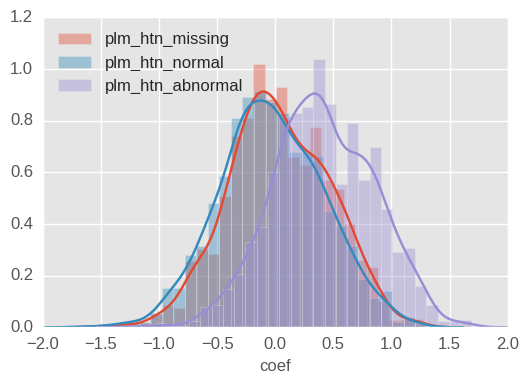

In [83]:
coefs = ['plm_htn_missing', 'plm_htn_normal', 'plm_htn_abnormal']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1,fluid_day2,fluid_day3
count,1800.000000,1800.000000,1800.000000
mean,-0.072303,-0.079464,0.219949
std,0.042156,0.061883,0.058418
min,-0.207968,-0.330706,0.025210
25%,-0.101368,-0.121794,0.182115
50%,-0.072990,-0.080956,0.218944
75%,-0.043763,-0.037804,0.260021
max,0.056918,0.140965,0.396149


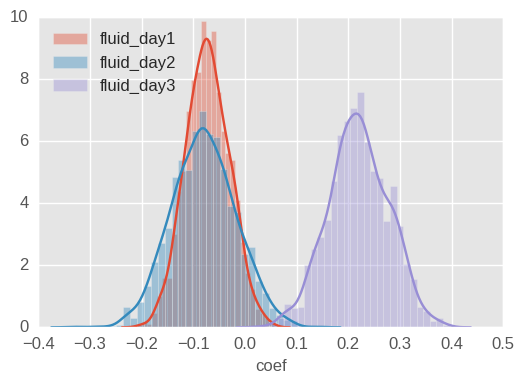

In [84]:
coefs = ['fluid_day1', 'fluid_day2', 'fluid_day3']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1_missing,fluid_day2_missing,fluid_day3_missing
count,1800.000000,1800.000000,1800.000000
mean,0.153875,0.214172,-0.121525
std,0.093184,0.079443,0.067780
min,-0.191396,-0.087121,-0.333735
25%,0.091926,0.160919,-0.168321
50%,0.156750,0.212095,-0.121325
75%,0.215799,0.268216,-0.077730
max,0.422079,0.459579,0.109871


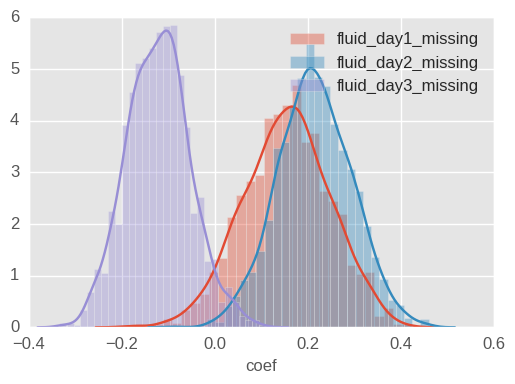

In [85]:
coefs = ['fluid_day1_missing', 'fluid_day2_missing', 'fluid_day3_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')